# Изучение клиентов фитнес-центра

Для сети пользователей фитнес-центров необходимо:
- спрогнозировать вероятность оттока клиента;
- сформировать типичные портреты пользователей;
- выявить основные признаки, наиболее сильно влияющие на отток.

## Загрузка и подготовка данных

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/obulygin/content/main/gym_churn/gym_churn.csv')

In [5]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   int64  
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,13,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,2,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,2,3,1.113884,1.120078,0


In [6]:
df.duplicated().sum()

0

In [7]:
# приведем названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()

In [8]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int')

In [9]:
df = df.rename(columns = {'avg_additional_charges_total' : 'other_revenue',
                            'avg_class_frequency_total' : 'freq_total',
                            'avg_class_frequency_current_month' : 'freq_curr_month',
                            'month_to_end_contract' : 'to_end_contract',
                            'promo_friends' : 'promo',
                            'near_location' : 'near_loc',
                            'group_visits' : 'group'
                           })

In [10]:
df['churn'].value_counts(normalize = True)

0    0.73475
1    0.26525
Name: churn, dtype: float64

In [11]:
(df['churn'].value_counts()[1] / (df['churn'].value_counts()[1] + df['churn'].value_counts()[0] )*100).round()

27.0

In [12]:
df.describe().round(2)

,gender,near_loc,partner,promo,phone,contract_period,group,age,other_revenue,to_end_contract,lifetime,freq_total,freq_curr_month,churn
count,4000.00,4000.00,4000.00,4000.00,4000.0,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00
mean,0.51,0.85,0.49,0.31,0.9,4.68,0.41,29.18,146.94,5.01,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.3,4.55,0.49,3.26,96.36,3.90,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.0,1.00,0.00,18.00,0.15,2.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.0,1.00,0.00,27.00,68.87,2.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.0,1.00,0.00,29.00,136.22,2.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.0,6.00,1.00,31.00,210.95,7.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.0,12.00,1.00,41.00,552.59,13.00,31.00,6.02,6.15,1.00


In [14]:
df.groupby('churn').agg('mean').round(2).reset_index()

,churn,gender,near_loc,partner,promo,phone,contract_period,group,age,other_revenue,to_end_contract,lifetime,freq_total,freq_curr_month
0,0,0.51,0.87,0.53,0.35,0.9,5.75,0.46,29.98,158.45,5.89,4.71,2.02,2.03
1,1,0.51,0.77,0.36,0.18,0.9,1.73,0.27,26.99,115.08,2.58,0.99,1.47,1.04


<Axes: >

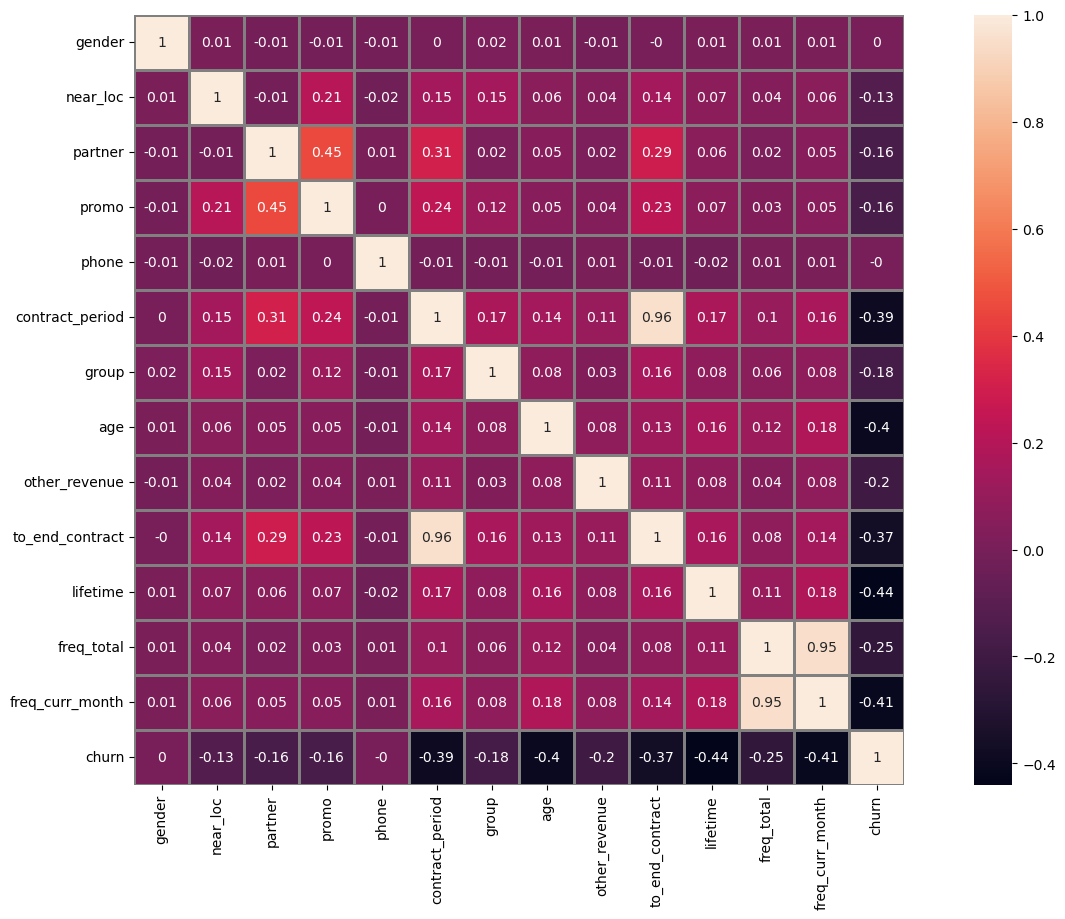

In [15]:
plt.figure(figsize= (18, 10))

sns.heatmap(df.corr().round(2), annot = True, square = True, linewidths=1, linecolor='gray')

In [16]:
gym = df.drop('to_end_contract', axis = 1)
gym = gym.drop('freq_curr_month', axis = 1)

In [17]:
binary_list = []
not_binary_list = []

for col in gym.drop('churn', axis = 1).columns:
    if gym[col].min() == 0 and gym[col].max() == 1:
        binary_list.append(col)
    else:
        not_binary_list.append(col)

print(binary_list)
print(not_binary_list)

['gender', 'near_loc', 'partner', 'promo', 'phone', 'group']
['contract_period', 'age', 'other_revenue', 'lifetime', 'freq_total']


In [18]:
gym_bin = gym[binary_list]
gym_not_bin = gym[not_binary_list]

gym_bin['churn'] = gym['churn']
gym_not_bin['churn'] = gym['churn']

/var/folders/ks/bqxz1yvx2mjcsnh9lynjm30c0000gn/T/ipykernel_35515/3513076241.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gym_bin['churn'] = gym['churn']
/var/folders/ks/bqxz1yvx2mjcsnh9lynjm30c0000gn/T/ipykernel_35515/3513076241.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gym_not_bin['churn'] = gym['churn']


In [19]:
display(gym_bin.head(2))
display(gym_not_bin.head(2))

,gender,near_loc,partner,promo,phone,group,churn
0,1,1,1,1,0,1,0
1,0,1,0,0,1,1,0


,contract_period,age,other_revenue,lifetime,freq_total,churn
0,6,29,14.227470,3,0.020398,0
1,12,31,113.202938,7,1.922936,0


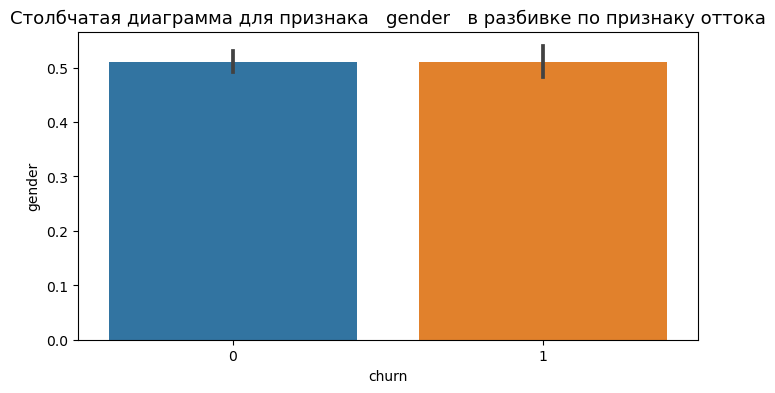

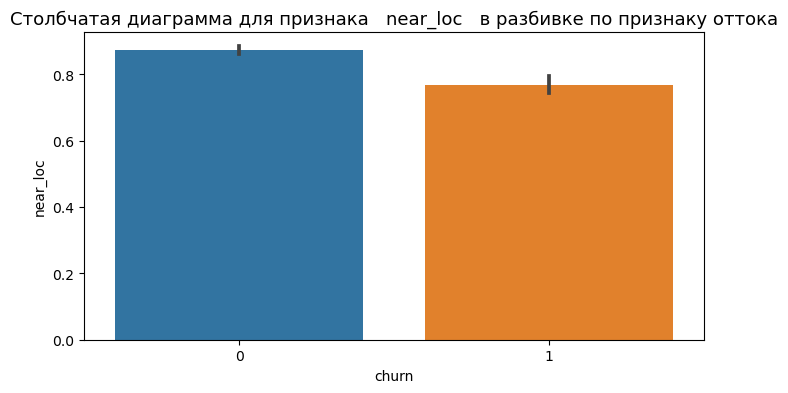

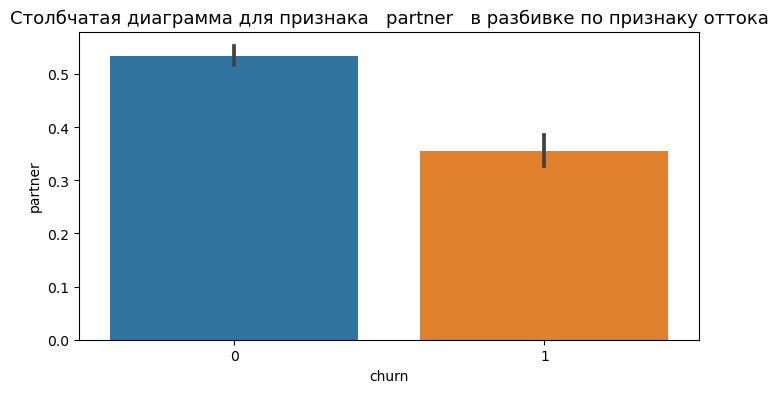

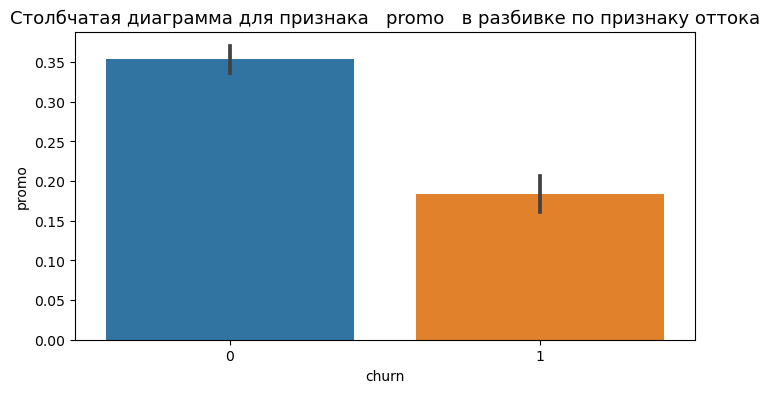

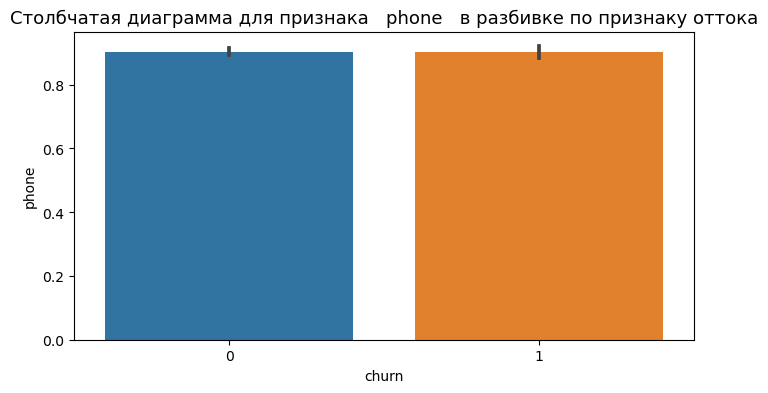

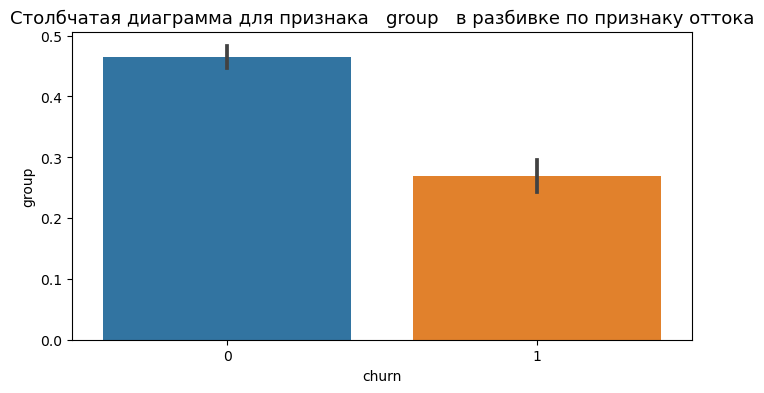

In [20]:
for col in binary_list:
    fig, ax = plt.subplots(figsize=(8,4))
    plt.title('Столбчатая диаграмма для признака   ' + col + '   в разбивке по признаку оттока', fontsize = 13)
    ax = sns.barplot(data = gym_bin,  x = 'churn', y = col);
    ax.yaxis.grid = True
    plt.show()

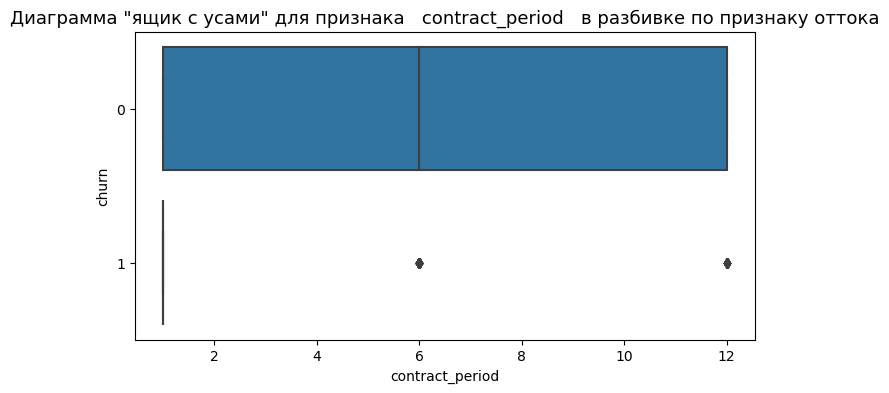

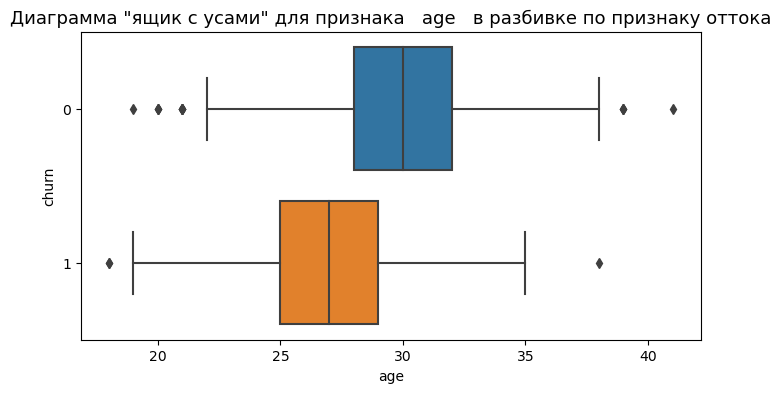

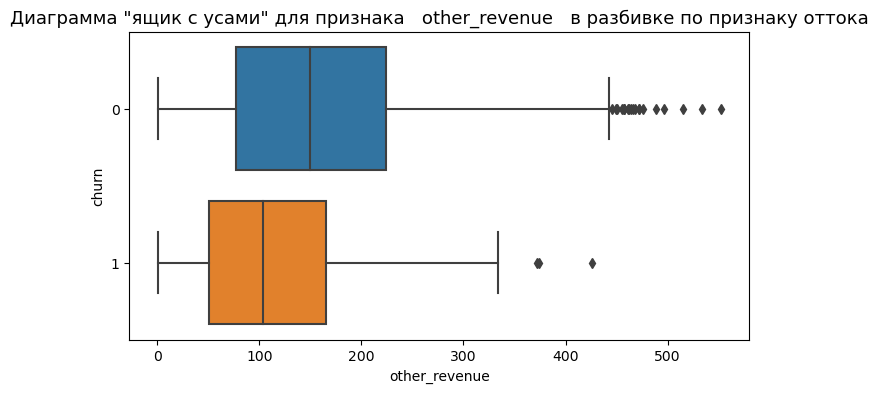

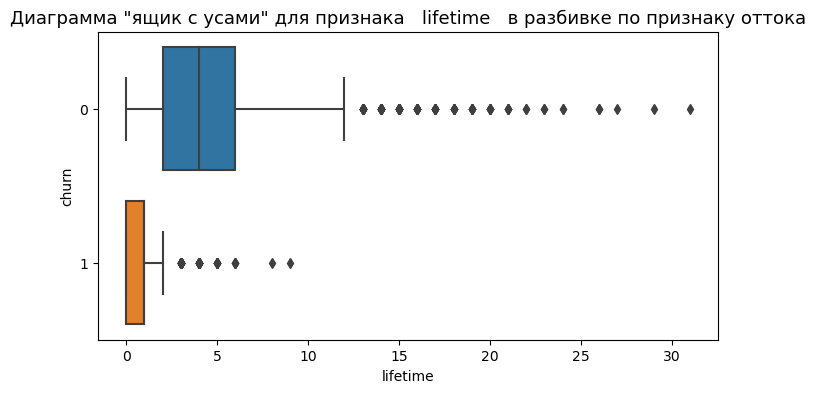

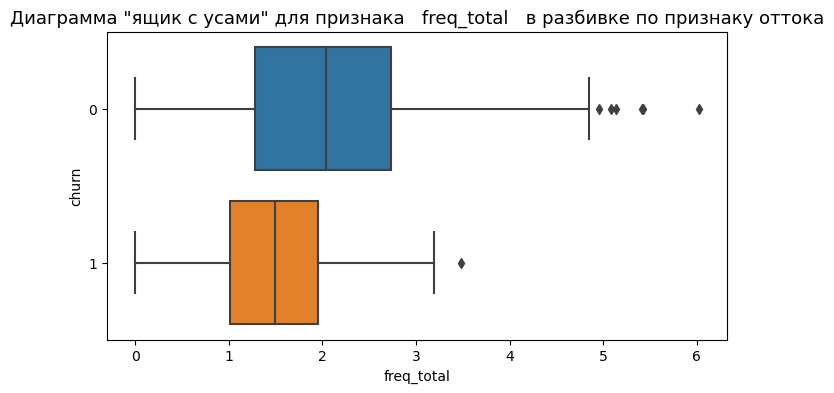

In [22]:
for col in not_binary_list:
    fig, ax = plt.subplots(figsize=(8,4))
    plt.title('Диаграмма "ящик с усами" для признака   ' + col + '   в разбивке по признаку оттока', fontsize = 13)
    ax = sns.boxplot(data = gym_not_bin, orient = 'h', x = col, y = 'churn')
    ax.yaxis.grid = True
    plt.show()

In [23]:
X = gym.drop('churn', axis = 1)
y = gym['churn']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)



In [24]:

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

X_test_st = scaler.transform(X_test)

X_train_st[:2]

array([[-1.01511421,  0.4175068 ,  1.03175391,  1.4800097 ,  0.31628211,
         1.60502986, -0.84769226,  0.57944798,  0.37161711,  1.12734972,
         1.75580418],
       [-1.01511421,  0.4175068 , -0.96922337, -0.67567125,  0.31628211,
        -0.81299073, -0.84769226,  0.27046055, -1.09697378,  5.88138322,
        -0.2239674 ]])

In [25]:
def print_all_metrics(y_true, y_pred, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [26]:
lr_model = LogisticRegression(random_state = 0)
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]
print_all_metrics(y_test, lr_predictions, title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.81


In [27]:
rf_model =  RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train_st, y_train)
rf_predictions =  rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]
print_all_metrics(y_test, rf_predictions,  title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.89
	Precision: 0.79
	Recall: 0.76


In [28]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [31]:
linked = linkage(X_sc, method = 'ward')
linked

array([[7.13000000e+02, 2.03300000e+03, 1.27048836e-02, 2.00000000e+00],
       [7.93000000e+02, 3.20500000e+03, 5.90387919e-02, 2.00000000e+00],
       [7.50000000e+01, 1.64600000e+03, 6.49761006e-02, 2.00000000e+00],
       ...,
       [7.98500000e+03, 7.99500000e+03, 8.41193602e+01, 2.57000000e+03],
       [7.98600000e+03, 7.99600000e+03, 8.97620484e+01, 2.95600000e+03],
       [7.99200000e+03, 7.99700000e+03, 9.53923405e+01, 4.00000000e+03]])

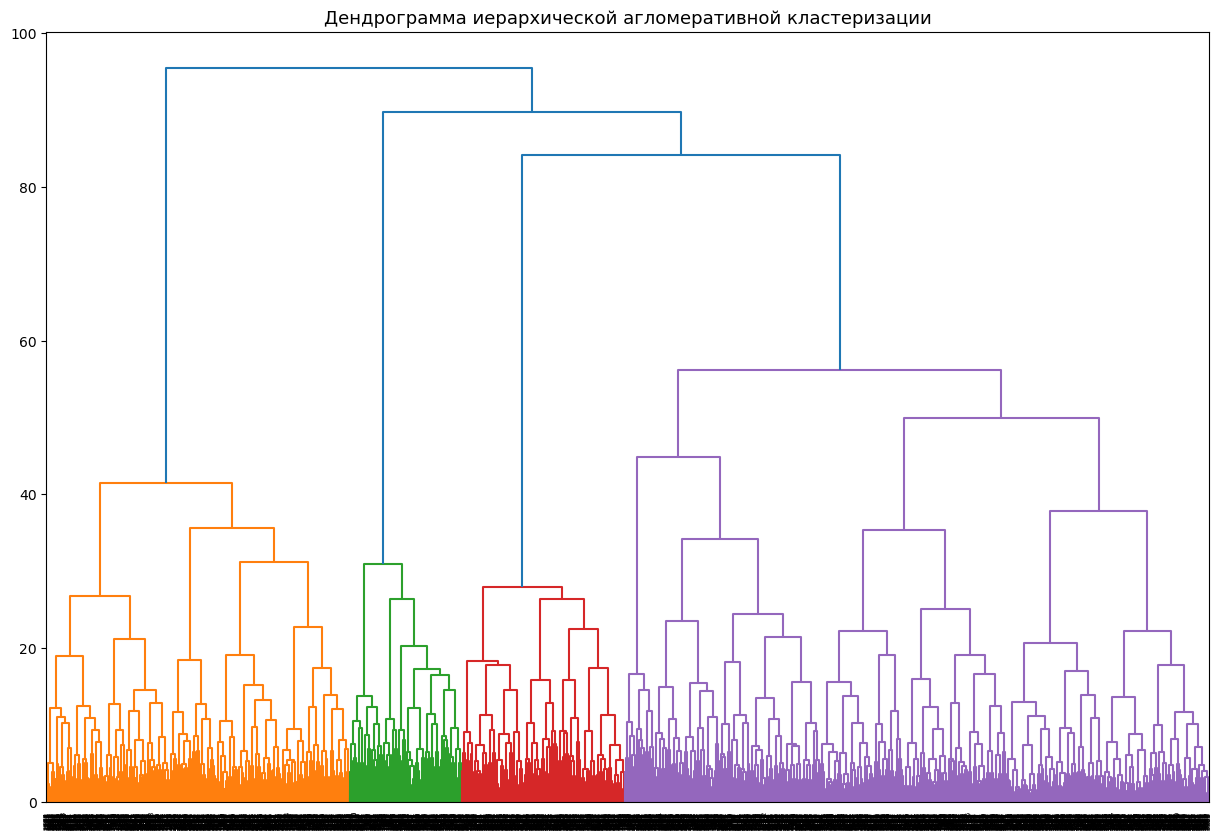

In [32]:
plt.figure(figsize=(15, 10))
plt.title('Дендрограмма иерархической агломеративной кластеризации', fontsize = 13)
dendrogram(linked, orientation='top')
plt.show()

In [33]:
km = KMeans(n_clusters = 5, random_state = 0)

In [34]:
labels = km.fit_predict(X_sc)

In [35]:
print(labels[:10])

[4 0 2 4 4 1 4 2 4 2]


In [36]:
gym['cluster_km'] = labels
display(gym.head(3))

X['cluster_km']= labels


,gender,near_loc,partner,promo,phone,contract_period,group,age,other_revenue,lifetime,freq_total,churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,3,0.020398,0,4
1,0,1,0,0,1,12,1,31,113.202938,7,1.922936,0,0
2,0,1,1,0,1,1,0,28,129.448479,2,1.859098,0,2


In [37]:
churn = gym.groupby('cluster_km').agg({'cluster_km':'count', 'churn' : 'sum'})
churn = churn.rename(columns = {'cluster_km':'users_count', 'churn':'churn_count'})
churn['churn_share'] = (churn['churn_count'] / churn['users_count']).round(2)
churn

,users_count,churn_count,churn_share
cluster_km,,,
0,642,9,0.01
1,881,352,0.40
2,824,319,0.39
3,608,245,0.40
4,1045,136,0.13


In [38]:
display(gym.groupby('cluster_km').mean())

,gender,near_loc,partner,promo,phone,contract_period,group,age,other_revenue,lifetime,freq_total,churn
cluster_km,,,,,,,,,,,,
0,0.526480,0.990654,0.532710,0.026480,0.889408,9.235202,0.562305,30.557632,177.742542,6.515576,2.243370,0.014019
1,1.000000,1.000000,0.189557,0.081725,0.905789,2.043133,0.364359,28.568672,135.523248,2.694665,1.802055,0.399546
2,0.000000,1.000000,0.200243,0.066748,0.904126,2.166262,0.349515,28.683252,134.867987,2.675971,1.679109,0.387136
3,0.501645,0.000000,0.488487,0.074013,0.912829,2.962171,0.226974,28.692434,136.926356,2.952303,1.768858,0.402961
4,0.494737,0.995215,0.933971,1.000000,0.904306,7.090909,0.517703,29.540670,153.000739,4.155024,1.941793,0.130144


In [39]:
gym_bin_cl = gym[binary_list]
gym_not_bin_cl = gym[not_binary_list]

gym_bin_cl['churn'] = gym['churn']
gym_not_bin_cl['churn'] = gym['churn']
gym_bin_cl['cluster_km'] = gym['cluster_km']
gym_not_bin_cl['cluster_km'] = gym['cluster_km']

/var/folders/ks/bqxz1yvx2mjcsnh9lynjm30c0000gn/T/ipykernel_35515/1414156527.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gym_bin_cl['churn'] = gym['churn']
/var/folders/ks/bqxz1yvx2mjcsnh9lynjm30c0000gn/T/ipykernel_35515/1414156527.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gym_not_bin_cl['churn'] = gym['churn']
/var/folders/ks/bqxz1yvx2mjcsnh9lynjm30c0000gn/T/ipykernel_35515/1414156527.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [40]:
display(gym_bin_cl.head(2))
display(gym_not_bin_cl.head(2))

,gender,near_loc,partner,promo,phone,group,churn,cluster_km
0,1,1,1,1,0,1,0,4
1,0,1,0,0,1,1,0,0


,contract_period,age,other_revenue,lifetime,freq_total,churn,cluster_km
0,6,29,14.227470,3,0.020398,0,4
1,12,31,113.202938,7,1.922936,0,0


In [41]:
print(gym_bin_cl.shape)
print(gym_not_bin_cl.shape)

(4000, 8)
(4000, 7)


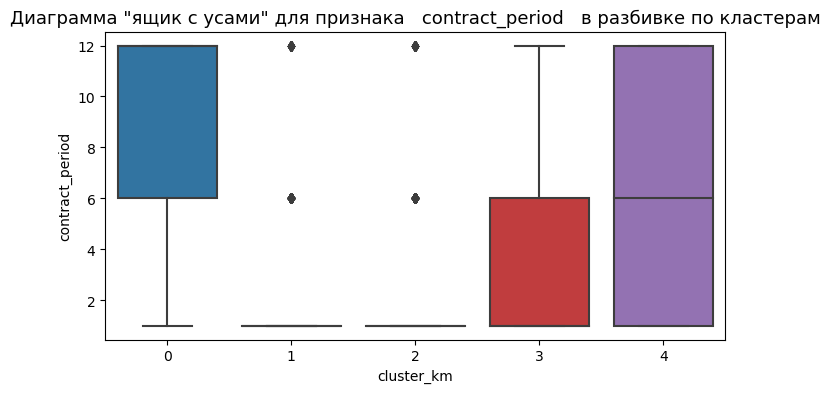

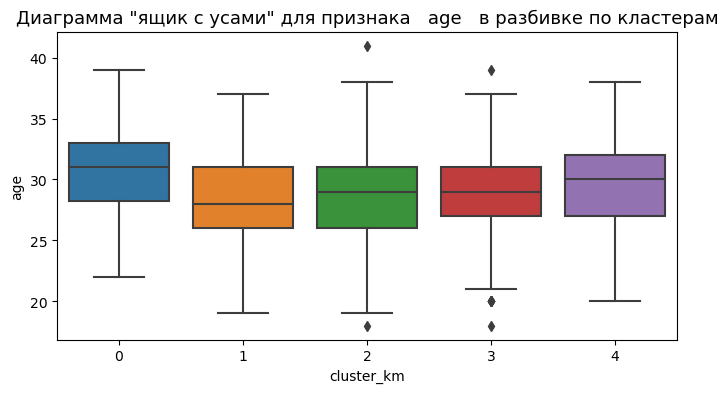

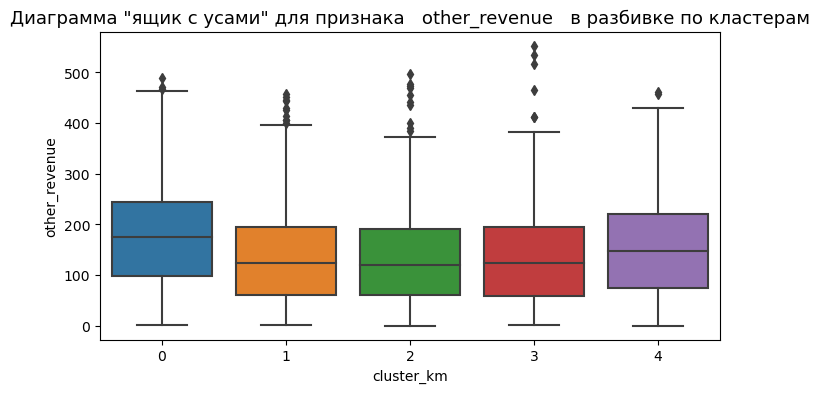

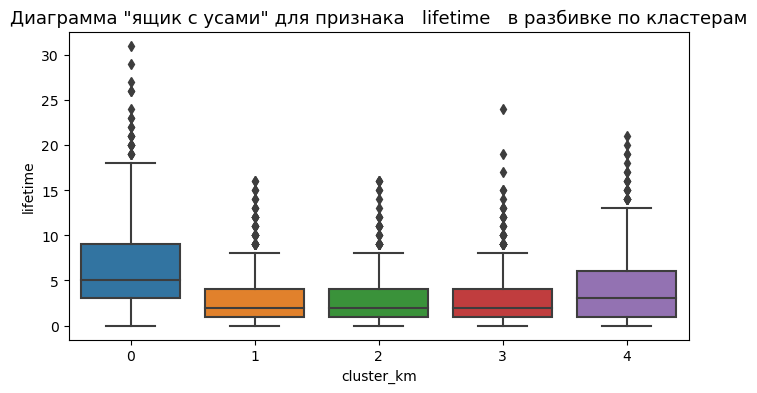

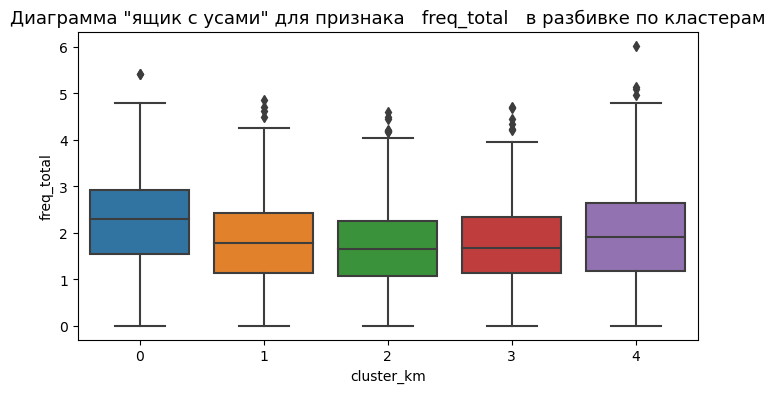

In [42]:
for col in not_binary_list:
    fig, ax = plt.subplots(figsize=(8,4))
    plt.title('Диаграмма "ящик с усами" для признака   ' + col + '   в разбивке по кластерам', fontsize = 13)
    ax = sns.boxplot(data = gym_not_bin_cl, y = col, x = 'cluster_km')
    ax.yaxis.grid = True
    plt.show()

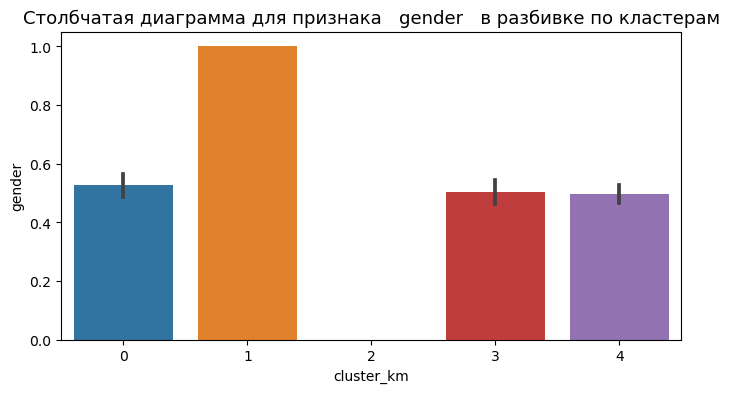

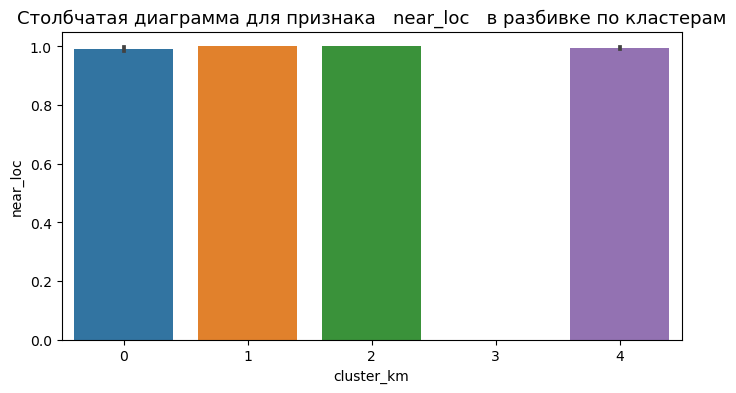

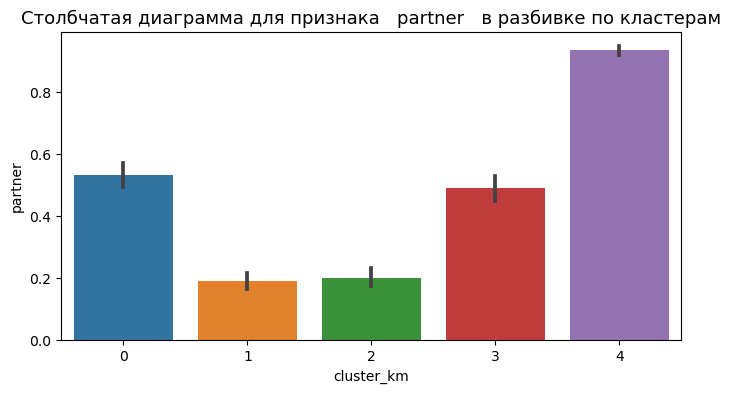

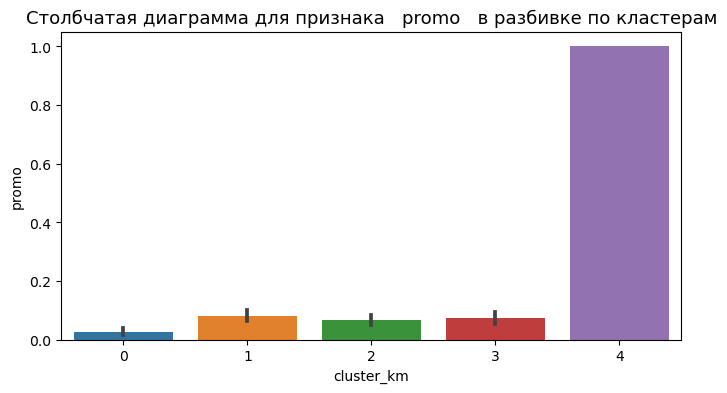

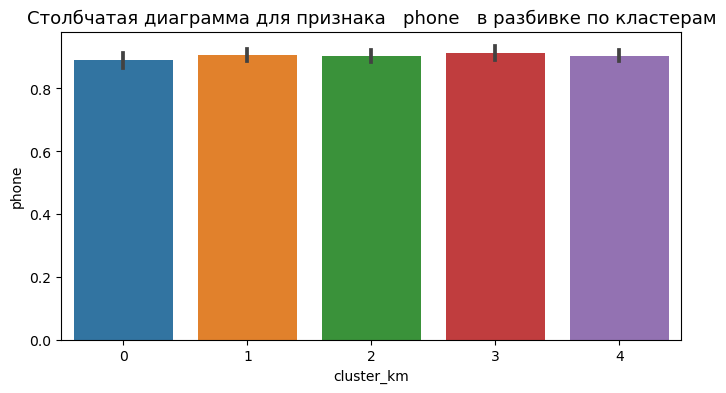

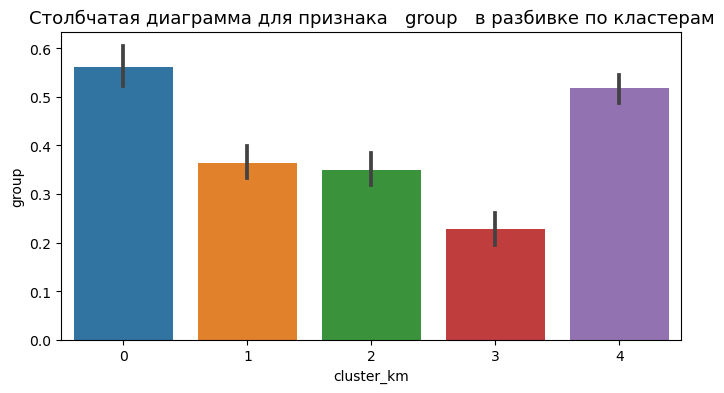

In [43]:
for col in binary_list:
    fig, ax = plt.subplots(figsize=(8,4))
    plt.title('Столбчатая диаграмма для признака   ' + col + '   в разбивке по кластерам', fontsize = 13)
    ax = sns.barplot(data = gym_bin_cl,  x = 'cluster_km', y = col);
    ax.yaxis.grid = True
    plt.show()